# ACLED

## API

### Rules
- All requests will be denied without a key and email address.
- This API only uses the GET (+) or POST request. 
- default = JSON unless specifically requested in either XML, CSV or TXT format.
- TXT format returns a plain text csv string, limit of 5000 lines of data (10000 rows for monadic) 
- return All fields by default.
- ACLED data is returned in date order DESC (starting with the latest).


In [2]:
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()
api_key = os.getenv("OWN_API_KEY")
email = os.getenv("OWN_EMAIL")
api_req = f"https://api.acleddata.com/acled/read?key={api_key}&email={email}"
print(api_req)

UKR_ISO = 804
RUS_ISO = 643

https://api.acleddata.com/acled/read?key=HfXIJXgNotYSYgiV-tUl&email=tristan.waddington@polytechnique.edu


In [20]:
def get_acled_data(
    base_req, year=None, iso=None, from_date=None, to_date=None, return_fields=None
):
    """Request the ACLED server for data
    :param base_req: str: The base request URL
    :param year: int: The year of the event
    :param iso: int: The country ISO code, individual or list
    :param event_date: str: The date of the event yyyy-mm-dd
    """
    if year:
        base_req += f"&year={year}"
    if iso:
        if type(iso) is list:
            base_req += "&" + ":OR:".join(f"iso={iso_country}" for iso_country in iso)
        else:
            base_req += f"&iso={iso}"
    if from_date is not None and to_date is not None:
        base_req += f"&event_date={from_date}|{to_date}&event_date_where=BETWEEN"
    if return_fields:
        base_req += f"&fields={'|'.join(return_fields)}"
    print(f"GET {base_req}")
    response = requests.get(base_req)
    return response.json()

The main query item will be the first item in the join,
followed by the other items split with :OR: 
```code
?key={api_key}&email={email address}&{fieldname}={text}:OR:{fieldname2}={text2}
&country={country} will return data where field = text OR field2 = text2 AND country =
country.
```

**Ukraine** ISO 804
**Russia** ISO 643

In [21]:
dec_events = get_acled_data(
    api_req, iso=[UKR_ISO, RUS_ISO], from_date="2024-12-01", to_date="2024-12-31"
)

GET https://api.acleddata.com/acled/read?key=HfXIJXgNotYSYgiV-tUl&email=tristan.waddington@polytechnique.edu&iso=804:OR:iso=643&event_date=2024-12-01|2024-12-31&event_date_where=BETWEEN


In [22]:
dec_events["data"]

[{'event_id_cnty': 'UKR196941',
  'event_date': '2024-12-06',
  'year': '2024',
  'time_precision': '1',
  'disorder_type': 'Strategic developments',
  'event_type': 'Strategic developments',
  'sub_event_type': 'Disrupted weapons use',
  'actor1': 'Military Forces of Russia (2000-)',
  'assoc_actor_1': '',
  'inter1': 'External/Other forces',
  'actor2': 'Military Forces of Ukraine (2019-) Navy',
  'assoc_actor_2': '',
  'inter2': 'State forces',
  'interaction': 'State forces-External/Other forces',
  'civilian_targeting': '',
  'iso': '804',
  'region': 'Europe',
  'country': 'Ukraine',
  'admin1': '',
  'admin2': '',
  'admin3': '',
  'location': 'Eastern Black Sea',
  'latitude': '43.3890',
  'longitude': '36.5190',
  'geo_precision': '3',
  'source': 'Novoye Vremya Ukraine',
  'source_scale': 'Subnational',
  'notes': 'Interception: On 6 December 2024, Russian military forces intercepted 2 Ukrainian naval drones (coded to Eastern Black Sea).',
  'fatalities': '0',
  'tags': '',
 

In [91]:
def display_fatalities(data):
    # Extract the data from dec_events

    # Create a DataFrame from the data
    df = pd.DataFrame(data)  # ["data"])

    # Convert the event_date to datetime
    df["event_date"] = pd.to_datetime(df["event_date"])
    # convert fatalities to int
    df["fatalities"] = df["fatalities"].astype(int)
    # Group by event_date and sum the fatalities
    fatalities_per_day = (
        df.groupby(["event_date", "country"])["fatalities"].sum().reset_index()
    )

    # Plot the evolution of fatalities per day
    plt.figure(figsize=(10, 6))
    for country in fatalities_per_day["country"].unique():
        country_data = fatalities_per_day[fatalities_per_day["country"] == country]
        plt.plot(
            country_data["event_date"],
            country_data["fatalities"],
            marker="o",
            label=country,
        )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Fatalities")
    plt.title("Evolution of Fatalities per Day in Russia-Ukraine War")
    plt.grid(True)
    plt.show()

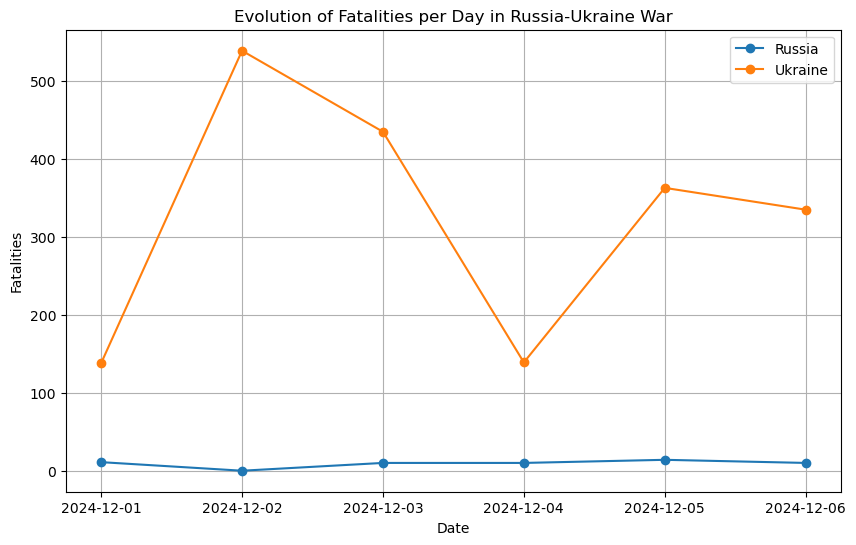

In [79]:
display_fatalities(dec_events)

In [80]:
df.keys()

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')

In [81]:
df[["disorder_type", "event_type", "sub_event_type"]].value_counts()

disorder_type           event_type                  sub_event_type                     
Political violence      Battles                     Armed clash                            332
                        Explosions/Remote violence  Air/drone strike                       249
                                                    Shelling/artillery/missile attack      152
Strategic developments  Strategic developments      Disrupted weapons use                   40
Political violence      Battles                     Non-state actor overtakes territory      7
                        Explosions/Remote violence  Remote explosive/landmine/IED            3
Demonstrations          Protests                    Peaceful protest                         2
Political violence      Battles                     Government regains territory             1
                        Violence against civilians  Attack                                   1
Name: count, dtype: int64

In [82]:
rus_dec_events = get_acled_data(
    api_req, iso=RUS_ISO, from_date="2024-12-01", to_date="2024-12-31"
)

GET https://api.acleddata.com/acled/read?key=HfXIJXgNotYSYgiV-tUl&email=tristan.waddington@polytechnique.edu&iso=643&event_date=2024-12-01|2024-12-31&event_date_where=BETWEEN


In [83]:
df_rus = rus_dec_events["data"]
df_rus = pd.DataFrame(df_rus)
df_rus["event_date"] = pd.to_datetime(df_rus["event_date"])

In [84]:
df_rus

event_id_cnty event_date  year time_precision       disorder_type  \
0        RUS27743 2024-12-06  2024              1  Political violence   
1        RUS27748 2024-12-06  2024              1  Political violence   
2        RUS27751 2024-12-06  2024              1  Political violence   
3        RUS27715 2024-12-06  2024              1  Political violence   
4        RUS27716 2024-12-06  2024              1  Political violence   
..            ...        ...   ...            ...                 ...   
264      RUS27567 2024-12-01  2024              1  Political violence   
265      RUS27568 2024-12-01  2024              1  Political violence   
266      RUS27569 2024-12-01  2024              1  Political violence   
267      RUS27571 2024-12-01  2024              1  Political violence   
268      RUS27741 2024-12-01  2024              1  Political violence   

                     event_type    sub_event_type  \
0                       Battles       Armed clash   
1                       Battles       Armed clash   
2                       Battles       Armed clash   
3    Explosions/Remote violence  Air/drone strike   
4    Explosions/Remote violence  Air/drone strike   
..                          ...               ...   
264  Explosions/Remote violence  Air/drone strike   
265  Explosions/Remote violence  Air/drone strike   
266  Explosions/Remote violence  Air/drone strike   
267  Explosions/Remote violence  Air/drone strike   
268  Explosions/Remote violence  Air/drone strike   

                                           actor1  \
0               Military Forces of Russia (2000-)   
1               Military Forces of Russia (2000-)   
2               Military Forces of Russia (2000-)   
3    Military Forces of Ukraine (2019-) Air Force   
4    Military Forces of Ukraine (2019-) Air Force   
..                                            ...   
264   Military Forces of Russia (2000-) Air Force   
265   Military Forces of Russia (2000-) Air Force   
266   Military Forces of Russia (2000-) Air Force   
267   Military Forces of Russia (2000-) Air Force   
268                  Unidentified Military Forces   

                          assoc_actor_1                 inter1  ...  \
0                                                 State forces  ...   
1                                                 State forces  ...   
2                                                 State forces  ...   
3    Military Forces of Ukraine (2019-)  External/Other forces  ...   
4    Military Forces of Ukraine (2019-)  External/Other forces  ...   
..                                  ...                    ...  ...   
264   Military Forces of Russia (2000-)           State forces  ...   
265   Military Forces of Russia (2000-)           State forces  ...   
266   Military Forces of Russia (2000-)           State forces  ...   
267   Military Forces of Russia (2000-)           State forces  ...   
268                                      External/Other forces  ...   

             location latitude longitude geo_precision  \
0          Viktorovka  51.2298   34.8925             2   
1        Nizhnii Klin  51.2817   35.0708             2   
2    Novaya Sorochina  51.3582   35.2268             2   
3           Shebekino  50.4106   36.8935             1   
4            Razumnoe  50.5348   36.6841             1   
..                ...      ...       ...           ...   
264       Goncharovka  51.1889   35.2498             2   
265       Zaoleshenka  51.2026   35.2579             2   
266         Kurilovka  51.1375   35.2706             2   
267       Nikolayevka  51.3329   35.2116             2   
268   Maloyaroslavets  55.0089   36.4609             2   

                            source             source_scale  \
0    Ministry of Defence of Russia                 Regional   
1    Ministry of Defence of Russia                 Regional   
2    Ministry of Defence of Russia                 Regional   
3                         Telegram                N

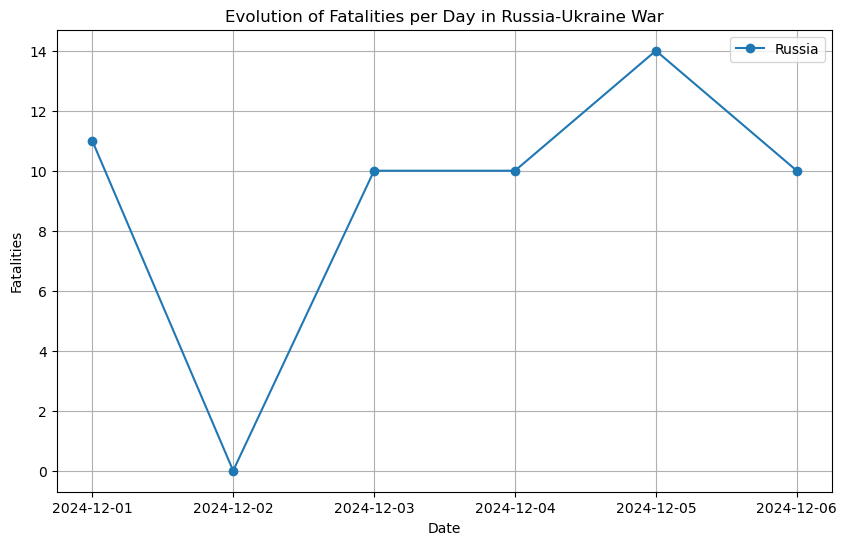

In [85]:
display_fatalities(rus_dec_events)

In [86]:
return_fields = [
    "event_date",
    "country",
    "admin1",
    "fatalities",
    "latitude",
    "longitude",
]
events_2024 = get_acled_data(
    api_req,
    from_date="2024-01-01",
    to_date="2024-11-30",
    iso=[UKR_ISO, RUS_ISO],
    return_fields=return_fields,
)
print(f"{len(events_2024['data'])} events in 2024")

GET https://api.acleddata.com/acled/read?key=HfXIJXgNotYSYgiV-tUl&email=tristan.waddington@polytechnique.edu&iso=804:OR:iso=643&event_date=2024-01-01|2024-11-30&event_date_where=BETWEEN&fields=event_date|country|fatalities|latitude|longitude
5000 events in 2024


In [87]:
events_2024["data"][-1]

{'event_date': '2024-11-06',
 'country': 'Ukraine',
 'fatalities': '0',
 'latitude': '47.9170',
 'longitude': '37.2297'}

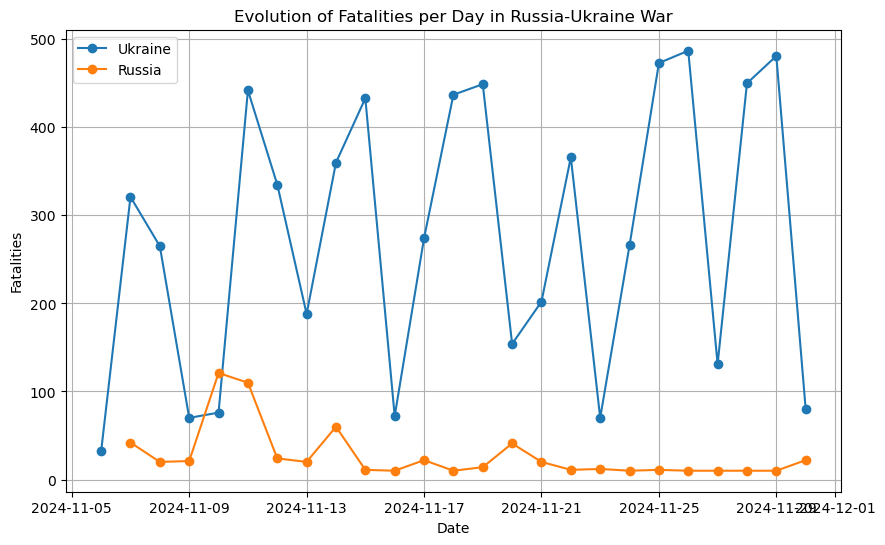

In [88]:
display_fatalities(events_2024)

<Axes: xlabel='event_date'>

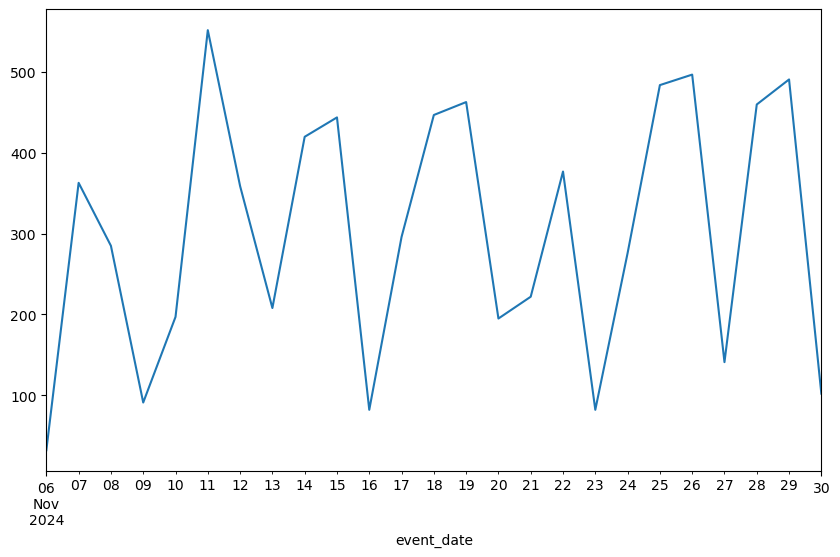

In [89]:
df_2024 = pd.DataFrame(events_2024["data"])
df_2024["event_date"] = pd.to_datetime(df_2024["event_date"])
df_2024["fatalities"] = df_2024["fatalities"].astype(int)
df_2024.groupby("event_date")["fatalities"].sum().plot(figsize=(10, 6))

In [56]:
# Request the server by pages, and merge by batches of 5000 rows
def get_acled_data_batched(base_req):
    """Request the ACLED server for data by batch
    :param base_req: str: The base request URL
    """
    data = []
    page = 1
    while True:
        response = requests.get(f"{base_req}&page={page}")
        page_data = response.json()
        if not page_data["data"]:
            break
        data.extend(page_data["data"])
        page += 1
        if page % 10 == 0:
            print(f"Page {page}")
    return data


In [78]:
all_req = "https://api.acleddata.com/acled/read?key=HfXIJXgNotYSYgiV-tUl&email=tristan.waddington@polytechnique.edu&iso=804:OR:iso=643&event_date=2024-01-01|2024-12-31&event_date_where=BETWEEN&fields=event_date|country|admin1|fatalities|latitude|longitude"
all_2024_events = get_acled_data_batched(all_req)
print(f"{len(all_2024_events)} events in 2024")

Page 10
64531 events in 2024


In [82]:
all_2024_events[-1]

{'event_date': '2024-01-01',
 'country': 'Ukraine',
 'admin1': 'Kherson',
 'fatalities': '0',
 'latitude': '47.3784',
 'longitude': '33.9647'}

In [86]:
df_all_2024_events = pd.DataFrame(all_2024_events)
df_all_2024_events["event_date"] = pd.to_datetime(df_all_2024_events["event_date"])
df_all_2024_events["fatalities"] = df_all_2024_events["fatalities"].astype(int)
df_all_2024_events.head()

event_date  country    admin1  fatalities latitude longitude
0 2024-12-06  Ukraine                     0  43.3890   36.5190
1 2024-12-06   Russia     Kursk           0  51.2298   34.8925
2 2024-12-06   Russia     Kursk           0  51.2817   35.0708
3 2024-12-06   Russia     Kursk           0  51.3582   35.2268
4 2024-12-06   Russia  Belgorod           0  50.4106   36.8935

In [97]:
# fill the missing values in the admin1 column with the country
# df_all_2024_events["admin1"] = df_all_2024_events["admin1"].replace('', df_all_2024_events["country"])
# Create a new location column with the admin1 if different form "", else the country
df_all_2024_events["location"] = df_all_2024_events["admin1"]
df_all_2024_events["location"] = df_all_2024_events["location"].where(
    df_all_2024_events["location"] != "", df_all_2024_events["country"]
)
# keep only the regions with more than 10 events
region_count = df_all_2024_events["location"].value_counts()
regions_to_keep = region_count[region_count > 10].index

df_all_2024_events = df_all_2024_events[
    df_all_2024_events["location"].isin(regions_to_keep)
]
events_by_admin = (
    df_all_2024_events.groupby(["event_date", "location"])["fatalities"].sum().unstack()
)
events_by_admin.fillna(0, inplace=True)
events_by_admin.head()

location    Astrakhan  Belgorod  Bryansk  Chelyabinsk  Cherkasy  Chernihiv  \
event_date                                                                   
2024-01-01        0.0       0.0      0.0          0.0       0.0        0.0   
2024-01-02        0.0       1.0      0.0          0.0       0.0        0.0   
2024-01-03        0.0       0.0      0.0          0.0       0.0        1.0   
2024-01-04        0.0       0.0      0.0          0.0       0.0        0.0   
2024-01-05        0.0       0.0      0.0          0.0       0.0        0.0   

location    Crimea  Dnipropetrovsk  Donetsk  Irkutsk  ...  Tula  Tver  \
event_date                                            ...               
2024-01-01     0.0             0.0     34.0      0.0  ...   0.0   0.0   
2024-01-02     0.0             0.0     23.0      0.0  ...   0.0   0.0   
2024-01-03     0.0             0.0     29.0      0.0  ...   0.0   0.0   
2024-01-04    23.0             0.0      3.0      0.0  ...   0.0   0.0   
2024-01-05     0.0             0.0     20.0      0.0  ...   0.0   0.0   

location    Ukraine  Vinnytsia  Volgograd  Volyn  Voronezh  Yaroslavl  \
event_date                                                              
2024-01-01      0.0        0.0        0.0    0.0       0.0        0.0   
2024-01-02      0.0        0.0        0.0    0.0       0.0        0.0   
2024-01-03      0.0        0.0        0.0    0.0       0.0        0.0   
2024-01-04      0.0        0.0        0.0    0.0       0.0        0.0   
2024-01-05      0.0        0.0        0.0    0.0       0.0        0.0   

location    Zaporizhia  Zhytomyr  
event_date                        
2024-01-01        10.0       0.0  
2024-01-02        14.0       0.0  
2024-01-03        12.0       0.0  
2024-01-04         0.0       0.0  
2024-01-05        10.0       0.0  

[5 rows x 60 columns]

In [101]:
nb_events_by_admin = (
    df_all_2024_events.groupby(["event_date", "location"])["fatalities"]
    .count()
    .unstack()
)
nb_events_by_admin.fillna(0, inplace=True)
nb_events_by_admin.head()

location    Astrakhan  Belgorod  Bryansk  Chelyabinsk  Cherkasy  Chernihiv  \
event_date                                                                   
2024-01-01        0.0      15.0      1.0          0.0       0.0        3.0   
2024-01-02        0.0      16.0      0.0          0.0       1.0        5.0   
2024-01-03        0.0      22.0      0.0          0.0       0.0        7.0   
2024-01-04        0.0      11.0      0.0          1.0       0.0        8.0   
2024-01-05        0.0       2.0      0.0          0.0       1.0        2.0   

location    Crimea  Dnipropetrovsk  Donetsk  Irkutsk  ...  Tula  Tver  \
event_date                                            ...               
2024-01-01     0.0            11.0     49.0      0.0  ...   0.0   0.0   
2024-01-02     1.0             5.0     41.0      0.0  ...   0.0   0.0   
2024-01-03     0.0             3.0     55.0      0.0  ...   0.0   0.0   
2024-01-04     4.0             4.0     43.0      0.0  ...   0.0   0.0   
2024-01-05     2.0             5.0     47.0      0.0  ...   0.0   0.0   

location    Ukraine  Vinnytsia  Volgograd  Volyn  Voronezh  Yaroslavl  \
event_date                                                              
2024-01-01      0.0        2.0        0.0    0.0       0.0        0.0   
2024-01-02      0.0        0.0        0.0    0.0       1.0        0.0   
2024-01-03      0.0        0.0        0.0    0.0       0.0        0.0   
2024-01-04      0.0        0.0        0.0    0.0       0.0        0.0   
2024-01-05      1.0        0.0        0.0    0.0       0.0        0.0   

location    Zaporizhia  Zhytomyr  
event_date                        
2024-01-01        16.0       0.0  
2024-01-02        15.0       0.0  
2024-01-03        17.0       0.0  
2024-01-04        17.0       0.0  
2024-01-05        25.0       0.0  

[5 rows x 60 columns]

In [102]:
nb_events_by_admin.to_csv("nb_events_by_admin_day.csv")
events_by_admin.to_csv("fatalities_by_admin_day.csv")

In [98]:
events_by_admin.sum().sort_values(ascending=False)

location
Donetsk                      30685.0
Kherson                      22264.0
Kharkiv                       8528.0
Kursk                         3268.0
Zaporizhia                    2262.0
Luhansk                       1165.0
Belgorod                       895.0
Sumy                           723.0
Dnipropetrovsk                 244.0
Moscow Oblast                  142.0
Odesa                          107.0
Mykolaiv                        83.0
Crimea                          81.0
Poltava                         61.0
Kyiv City                       44.0
Chernihiv                       37.0
Rostov                          27.0
Republic of Dagestan            23.0
Krasnodar                       22.0
Bryansk                         22.0
Tver                            10.0
Lviv                            10.0
Volgograd                        8.0
Saratov                          8.0
Vinnytsia                        5.0
Khmelnytskyi                     5.0
Moscow                       

In [ ]:
df_all_2024_events.groupby(["event_date", "location"])["fatalities"].sum().to_csv(
    "fatalities_target.csv"
)

In [105]:
df_all_2024_events.groupby(["event_date", "location"])["fatalities"].count().to_csv(
    "nb_events_target.csv"
)

In [100]:
regions_to_keep.to_list()

['Donetsk',
 'Sumy',
 'Belgorod',
 'Kharkiv',
 'Kherson',
 'Zaporizhia',
 'Kursk',
 'Chernihiv',
 'Luhansk',
 'Dnipropetrovsk',
 'Mykolaiv',
 'Kyiv City',
 'Odesa',
 'Bryansk',
 'Poltava',
 'Crimea',
 'Kirovohrad',
 'Cherkasy',
 'Krasnodar',
 'Rostov',
 'Moscow',
 'Khmelnytskyi',
 'Voronezh',
 'Vinnytsia',
 'Zhytomyr',
 'Oryol',
 'Moscow Oblast',
 'Saint Petersburg',
 'Lviv',
 'Kaluga',
 'Volgograd',
 'Ivano-Frankivsk',
 'Smolensk',
 'Lipetsk',
 'Tula',
 'Kyiv',
 'Rivne',
 'Sverdlovsk',
 'Republic of Bashkortostan',
 'Republic of Dagestan',
 'Ternopil',
 'Novosibirsk',
 'Republic of Chechnya',
 'Saratov',
 'Ryazan',
 'Chelyabinsk',
 'Republic of Tatarstan',
 'Nizhny Novgorod',
 'Samara',
 'Tver',
 'Volyn',
 'Yaroslavl',
 'Leningrad',
 'Ukraine',
 'Orenburg',
 'Astrakhan',
 'Tambov',
 'Perm',
 'Irkutsk',
 'Republic of Komi']

In [76]:
print(all_nov_events[0])
print(all_nov_events[-1])

{'event_date': '2024-11-30', 'country': 'Russia', 'fatalities': '1', 'latitude': '51.2298', 'longitude': '34.8925'}
{'event_date': '2024-01-01', 'country': 'Ukraine', 'fatalities': '0', 'latitude': '47.3784', 'longitude': '33.9647'}


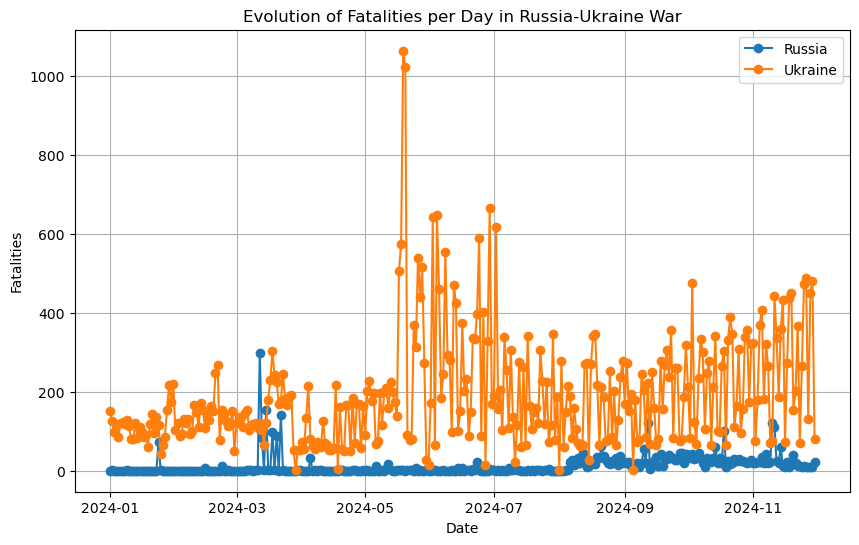

In [92]:
display_fatalities(all_nov_events)

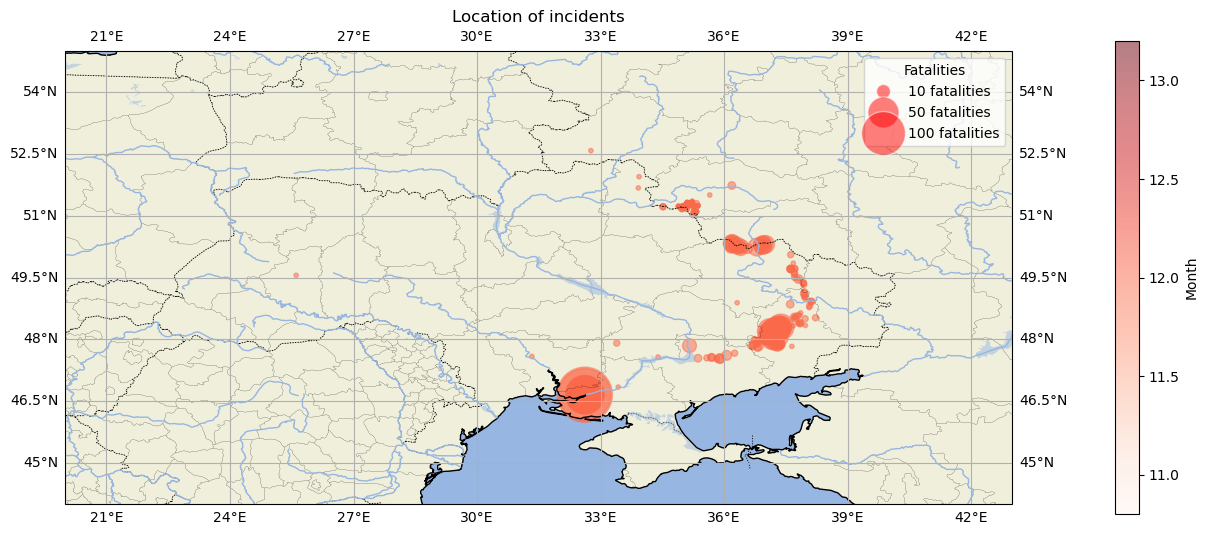

In [74]:
# Append the parent folder to path
import sys
from pathlib import Path
from importlib import reload

sys.path.append(str(Path().resolve().parent))

import src.display

reload(src.display)
from src.display import display_events_on_map

display_events_on_map(dec_events["data"])

In [35]:
dec_events["data"]

[{'event_id_cnty': 'UKR196941',
  'event_date': '2024-12-06',
  'year': '2024',
  'time_precision': '1',
  'disorder_type': 'Strategic developments',
  'event_type': 'Strategic developments',
  'sub_event_type': 'Disrupted weapons use',
  'actor1': 'Military Forces of Russia (2000-)',
  'assoc_actor_1': '',
  'inter1': 'External/Other forces',
  'actor2': 'Military Forces of Ukraine (2019-) Navy',
  'assoc_actor_2': '',
  'inter2': 'State forces',
  'interaction': 'State forces-External/Other forces',
  'civilian_targeting': '',
  'iso': '804',
  'region': 'Europe',
  'country': 'Ukraine',
  'admin1': '',
  'admin2': '',
  'admin3': '',
  'location': 'Eastern Black Sea',
  'latitude': '43.3890',
  'longitude': '36.5190',
  'geo_precision': '3',
  'source': 'Novoye Vremya Ukraine',
  'source_scale': 'Subnational',
  'notes': 'Interception: On 6 December 2024, Russian military forces intercepted 2 Ukrainian naval drones (coded to Eastern Black Sea).',
  'fatalities': '0',
  'tags': '',
 

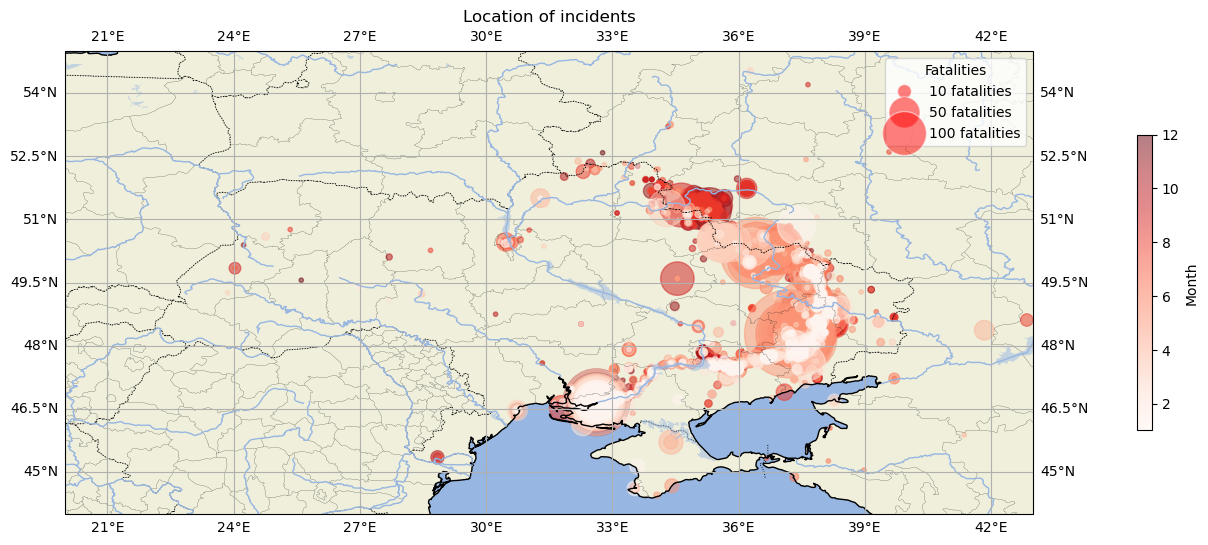

In [62]:
display_events_on_map(all_2024_events)

# Approx
To simplify, We can project the conflict along a vertical line. The latitude  will give enouth information about the location of the incident

/var/folders/vw/2kmjpl310zl2lwgnwpxsyw4r0000gn/T/ipykernel_25458/173051568.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  simplified_frontline = df.groupby('latitude_round').apply(


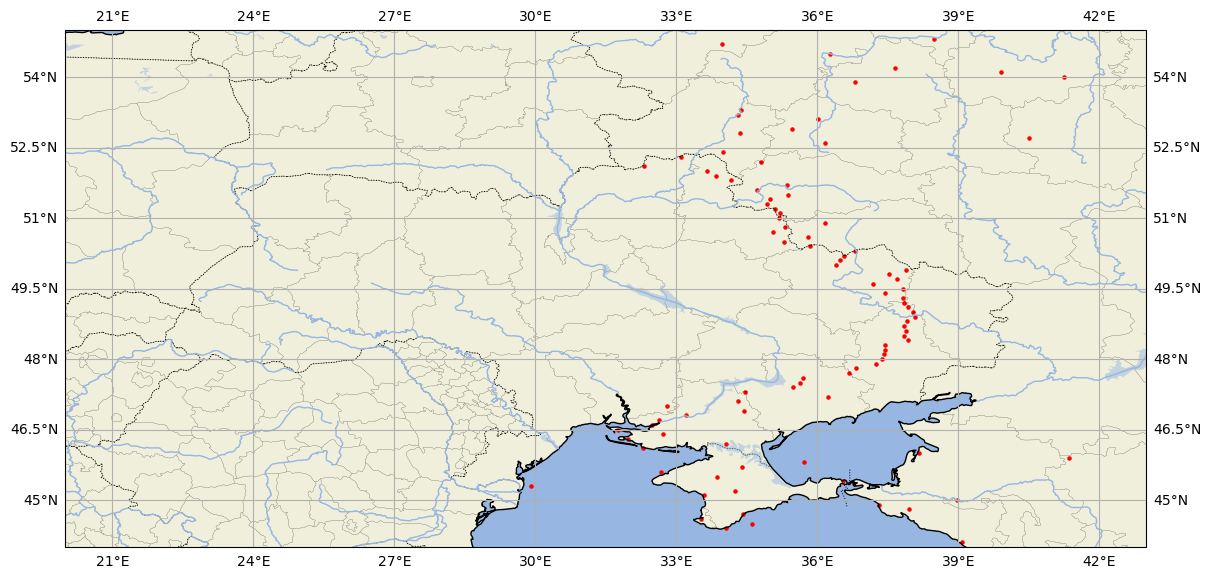

In [ ]:
df = pd.DataFrame(all_2024_events)
df_dates = pd.to_datetime(df["event_date"])
df = df[["fatalities", "latitude", "longitude"]].astype(float)
# round the lat by 0.1 degree
df["latitude_round"] = df["latitude"].round(1)
# try to display the front line
simplified_frontline = (
    df.groupby("latitude_round")
    .apply(
        lambda x: pd.Series(
            {
                "longitude": (x["longitude"] * x["fatalities"]).sum()
                / x["fatalities"].sum()
                if x["fatalities"].sum() > 0
                else x["longitude"].mean()
            }
        )
    )
    .reset_index()
)
fig = plt.figure(figsize=(12, 6), layout="constrained")
fig, ax = src.display.ukr_background_map(fig)
import cartopy.crs as ccrs

ax.scatter(
    simplified_frontline["longitude"],
    simplified_frontline["latitude_round"],
    s=5,
    transform=ccrs.PlateCarree(),
    color="red",
)


In [77]:
all_2024_events[0]

{'event_date': '2024-12-06',
 'country': 'Ukraine',
 'fatalities': '0',
 'latitude': '43.3890',
 'longitude': '36.5190'}

In [ ]:
# Merge the events and the fatalities
df_all_2024_events = pd.DataFrame(all_2024_events)
df_all_2024_events["event_date"] = pd.to_datetime(df_all_2024_events["event_date"])
df_all_2024_events["fatalities"] = df_all_2024_events["fatalities"].astype(int)


## Approx 2 : by region